# WIND TURBINE DATA ANALYSIS

## 0) IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 

## 1) IMPORT DATA

In [2]:
cwd = os.getcwd()
data_wd = cwd + '/data/la-haute-borne-data-2013-2016.csv'
data = pd.read_csv(data_wd,sep=';')

In [3]:
data.head()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
0,R80711,2014-09-25T09:40:00+02:00,-0.89,-0.99,0.00,0.28,18.150000,18.0,19.000000,0.27,...,NaN,NaN,289.97000,NaN,NaN,NaN,300.07999,NaN,NaN,NaN
1,R80711,2014-07-29T01:00:00+02:00,-0.99,-0.99,-0.99,0.00,23.010000,23.0,23.959999,0.07,...,NaN,NaN,249.77000,NaN,NaN,NaN,244.11000,NaN,NaN,NaN
2,R80711,2014-05-26T22:00:00+02:00,-0.99,-0.99,-0.99,0.00,22.000000,22.0,22.000000,0.00,...,NaN,NaN,239.24001,NaN,NaN,NaN,233.13000,NaN,NaN,NaN
3,R80711,2014-05-27T02:50:00+02:00,-0.99,-0.99,-0.99,0.00,20.389999,20.0,21.000000,0.41,...,NaN,NaN,257.63000,NaN,NaN,NaN,269.35001,NaN,NaN,NaN
4,R80711,2014-06-19T01:20:00+02:00,-0.99,-0.99,-0.99,0.00,23.010000,23.0,23.730000,0.05,...,NaN,NaN,13.18000,NaN,NaN,NaN,7.04000,NaN,NaN,NaN


## 2) DATA CLEANING AND PREPROCESSING

### CALENDAR FEATURES CREATION

In [4]:
data['Date_time'] = pd.to_datetime(data['Date_time'])
data.sort_values(by=['Date_time'], inplace=True, ascending=True)

data['Year'] = data['Date_time'].dt.year
data['Month'] = data['Date_time'].dt.month

In [5]:
data.head()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std,Year,Month
209184,R80711,2012-12-31 23:00:00,-1.00,-1.0,-1.0,0.0,12.76,12.0,13.0,0.36,...,180.25000,NaN,NaN,NaN,176.44000,NaN,NaN,NaN,2012,12
13935,R80711,2012-12-31 23:10:00,-1.00,-1.0,-1.0,0.0,12.71,12.0,13.0,0.38,...,183.28999,NaN,NaN,NaN,176.44000,NaN,NaN,NaN,2012,12
204824,R80711,2012-12-31 23:20:00,-1.00,-1.0,-1.0,0.0,12.81,12.0,13.0,0.31,...,185.08000,NaN,NaN,NaN,176.44000,NaN,NaN,NaN,2012,12
13931,R80711,2012-12-31 23:30:00,-1.00,-1.0,-1.0,0.0,12.70,12.0,13.0,0.38,...,190.33000,NaN,NaN,NaN,188.41000,NaN,NaN,NaN,2012,12
203,R80711,2012-12-31 23:40:00,-0.98,-1.0,-0.5,0.1,12.40,12.0,13.0,0.41,...,188.07001,NaN,NaN,NaN,192.89999,NaN,NaN,NaN,2012,12


### MISSING VALUES TREATMENT

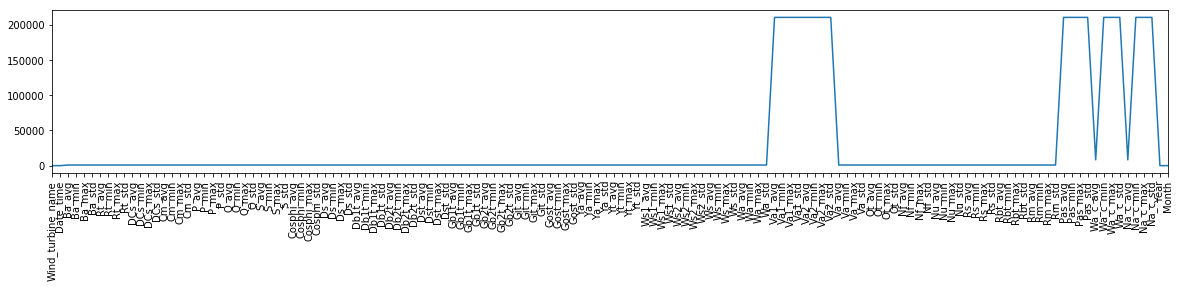

In [30]:
plt.figure(figsize=(20,3))
plt.plot(data.isnull().sum(axis = 0))
plt.xticks(rotation=90)
plt.margins(x=0)
plt.show()

In [7]:
print('List of columns deleted because of NaN count exceeds maximum threshold')
print(list(data.loc[:,data.isnull().sum(axis = 0) > 10000].columns))

List of columns deleted because of NaN count exceeds maximum threshold
['Va1_avg', 'Va1_min', 'Va1_max', 'Va1_std', 'Va2_avg', 'Va2_min', 'Va2_max', 'Va2_std', 'Pas_avg', 'Pas_min', 'Pas_max', 'Pas_std', 'Wa_c_min', 'Wa_c_max', 'Wa_c_std', 'Na_c_min', 'Na_c_max', 'Na_c_std']


In [8]:
df = data.loc[:,data.isnull().sum(axis = 0) < 10000]

In [9]:
df.head()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Wa_c_avg,Na_c_avg,Year,Month
209184,R80711,2012-12-31 23:00:00,-1.00,-1.0,-1.0,0.0,12.76,12.0,13.0,0.36,...,28.799999,0.03,5690.2798,4037.4900,7382.7202,612.64001,180.25000,176.44000,2012,12
13935,R80711,2012-12-31 23:10:00,-1.00,-1.0,-1.0,0.0,12.71,12.0,13.0,0.38,...,28.750000,0.01,5632.7202,3579.1001,7386.1099,746.62000,183.28999,176.44000,2012,12
204824,R80711,2012-12-31 23:20:00,-1.00,-1.0,-1.0,0.0,12.81,12.0,13.0,0.31,...,28.799999,0.03,6071.6899,4231.8799,8059.7798,853.60999,185.08000,176.44000,2012,12
13931,R80711,2012-12-31 23:30:00,-1.00,-1.0,-1.0,0.0,12.70,12.0,13.0,0.38,...,29.000000,0.07,6279.4702,4090.2900,8978.8799,1022.31000,190.33000,188.41000,2012,12
203,R80711,2012-12-31 23:40:00,-0.98,-1.0,-0.5,0.1,12.40,12.0,13.0,0.41,...,28.900000,0.05,6988.5698,4366.8901,9823.5400,1135.03000,188.07001,192.89999,2012,12


In [10]:
df.shape[0]

210095

In [11]:
df_no_na = df.dropna()
df_no_na.shape[0]

201867

### FILTERING IDLE/SHUTDOWN/STARTUP

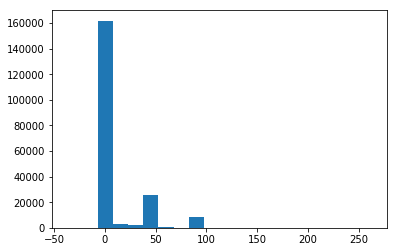

In [12]:
plt.hist(df_no_na['Ba_avg'],bins = 20)
plt.show()

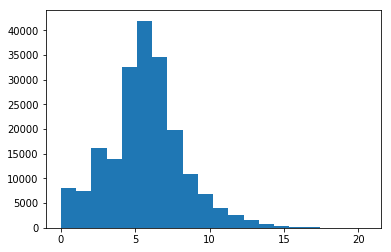

In [13]:
plt.hist(df_no_na['Ws_avg'],bins = 20)
plt.show()

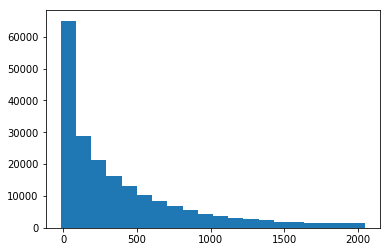

In [14]:
plt.hist(df_no_na['P_avg'],bins = 20)
plt.show()

In [28]:
df_clean = df_no_na[df_no_na['Ws_avg']>3]
df_clean = df_clean[df_clean['Ba_avg'] < 5]
df_clean = df_clean[df_clean['Ba_avg'] > -5]
df_clean.shape[0]

159329

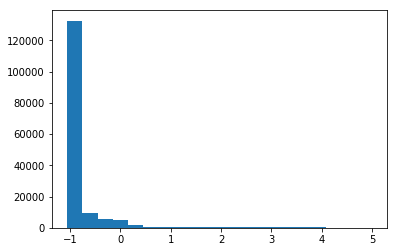

In [29]:
plt.hist(df_clean['Ba_avg'],bins = 20)
plt.show()

## POWER OUTPUT CALCULATION